# **Phân loại tin tức tiếng Việt sử dụng SVM**

## 1. Xác định bài toán

- Đầu vào bài toán: 1 đoạn tin tức tiếng Việt  
- Đầu ra: Lớp tương ứng với đoạn tin tức đó

- Dataset: VNews8td  
- Mô tả:  Được thu thập từ trang báo mạng VnExpress từ ngày 01/06/2023 - 01/06/2024. Gồm 8 lớp, chia train:val:test theo tỉ lệ 70:10:20. Mỗi văn bản sẽ gồm có tiêu đề và phần mô tả của bài báo  
- 8 lớp: 	
    * doisong (Đời sống)
	* giaoduc (Giáo dục)
	* khoahoc (Khoa học)
	* kinhte (Kinh tế)
	* suckhoe (Sức khỏe)
	* thegioi (Thế giới)
	* thethao (Thể thao)
	* thoisu (Thời sự)

### Import thư viện 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyvi import ViTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.metrics import classification_report

## 2. Tiền xử lý dữ liệu

In [2]:
train_df = pd.read_csv("VNews8td/train.tsv", sep='\t',header=None, names=['văn bản','lớp'])
test_df = pd.read_csv("VNews8td/test.tsv", sep='\t',header=None, names=['văn bản','lớp'])
val_df = pd.read_csv("VNews8td/val.tsv", sep='\t',header=None, names=['văn bản','lớp'])

In [3]:
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(31745, 2)
(9115, 2)
(4490, 2)


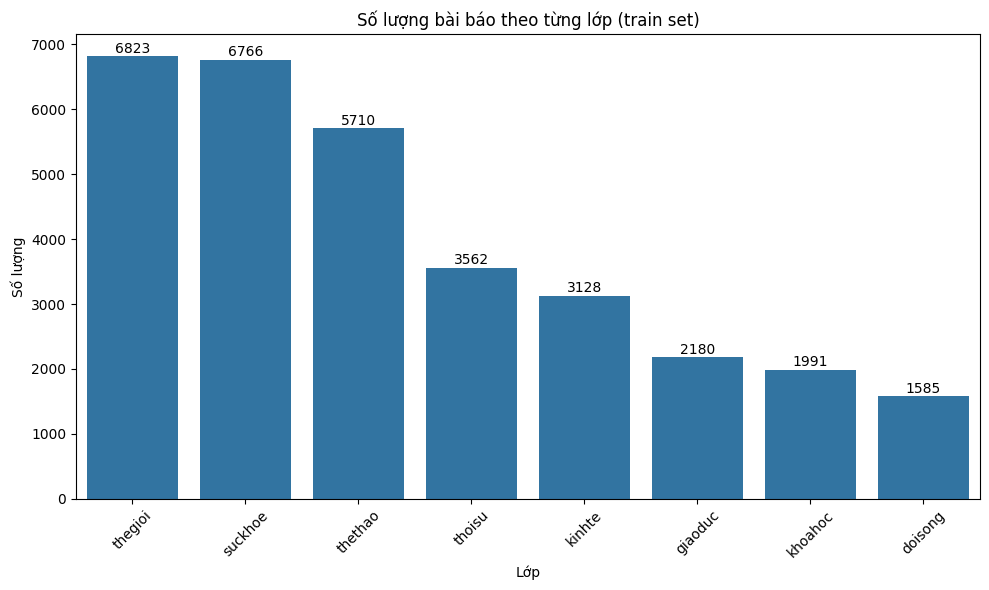

In [4]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=train_df, x='lớp', order=train_df['lớp'].value_counts().index)

plt.title('Số lượng bài báo theo từng lớp (train set)')
plt.xlabel('Lớp')
plt.ylabel('Số lượng')
plt.xticks(rotation=45)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 5,  
            f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Dữ liệu bị mất cân bằng giữa các lớp --> dùng class weighted, hoặc augment data 

In [5]:
tokens = ViTokenizer.tokenize(train_df['văn bản'][0]).split()
print(tokens)

['Ba_Lan', 'sa_thải', 'HLV', 'Santos', 'sau', 'sáu', 'trận', '.', 'Liên_đoàn', 'Bóng_đá', 'Ba_Lan', 'quyết_định', 'chia_tay', 'HLV', 'Fernando_Santos', ',', 'người', 'từng', 'đưa', 'Bồ_Đào_Nha', 'đến', 'chức', 'vô_địch', 'Euro', '2016', '.']


In [6]:
with open('vietnamese_stopwords.txt', 'r', encoding='utf-8') as f:
    stopwords = list(line.strip() for line in f)

def remove_stopwords(text):
    tokens = ViTokenizer.tokenize(text).split()
    filtered_tokens = [t for t in tokens if t not in stopwords]
    return ' '.join(filtered_tokens)

txt = remove_stopwords(train_df['văn bản'][0])
print(txt)

Ba_Lan sa_thải HLV Santos sáu trận . Liên_đoàn Bóng_đá Ba_Lan quyết_định chia_tay HLV Fernando_Santos , Bồ_Đào_Nha chức vô_địch Euro 2016 .


In [7]:
print("Danh sách 10 từ dừng đầu tiên (từ không mang ý nghĩa phân loại): ", stopwords[0:10])

Danh sách 10 từ dừng đầu tiên (từ không mang ý nghĩa phân loại):  ['a_lô', 'a_ha', 'ai', 'ai_ai', 'ai_nấy', 'ai_đó', 'alô', 'amen', 'anh', 'anh_ấy']


Chuyển dữ liệu từ dạng văn bản về dạng số để xử lý 

In [8]:
vectorizer = TfidfVectorizer(stop_words=stopwords)
X_train = vectorizer.fit_transform(train_df['văn bản'])
X_val = vectorizer.transform(val_df['văn bản'])
X_test = vectorizer.transform(test_df['văn bản'])


In [9]:
le = LabelEncoder()
y_train = le.fit_transform(train_df['lớp'])
y_val = le.transform(val_df['lớp'])
y_test = le.transform(test_df['lớp'])

In [10]:
print(le.classes_)

['doisong' 'giaoduc' 'khoahoc' 'kinhte' 'suckhoe' 'thegioi' 'thethao'
 'thoisu']


In [11]:
print("Dữ liệu training: ", X_train.shape, y_train.shape)
print("Dữ liệu validation: ", X_val.shape, y_val.shape)
print("Dữ liệu testing: ", X_test.shape, y_test.shape)


Dữ liệu training:  (31745, 15165) (31745,)
Dữ liệu validation:  (4490, 15165) (4490,)
Dữ liệu testing:  (9115, 15165) (9115,)


In [12]:
from sklearn.decomposition import PCA

# Giảm chiều TF-IDF về 2D
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_train.toarray()) 

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_train, cmap='tab10', alpha=0.5)
handles, indices = scatter.legend_elements()
labels = le.classes_ 

plt.legend(handles, labels, title="Lớp")
plt.title("PCA Visualization của X_train")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()


MemoryError: Unable to allocate 3.59 GiB for an array with shape (31745, 15165) and data type float64

Dữ liệu không linear, bị chồng chéo lên nhau --> nếu dùng kernel = 'linear' có thể không đạt được hiệu quả cao bằng 

## 3. Huấn luyện mô hình & đánh giá mô hình

*Lưu ý: Đánh giá trên tập validation*

### Kernel linear với C=1

In [13]:
print("- Training ...")
print("- Train size = {}".format(X_train.shape))
model = svm.SVC(kernel='linear', C=1)
model.fit(X_train, y_train)
print("- model - train complete")

- Training ...
- Train size = (31745, 15165)
- model - train complete


In [ ]:
print("- Testing ...")
y_val_pred = model.predict(X_val)
y_train_pred = model.predict(X_train)

print("\n Classification Report (Validation Set):")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))
print("\n Confusion Matrix (Validation Set):")
cm_val = confusion_matrix(y_val, y_val_pred)
print("\n Classification Report (Train Set):")
print(classification_report(y_train, y_train_pred, target_names=le.classes_))


- Testing ...

 Classification Report (Validation Set):
              precision    recall  f1-score   support

     doisong       0.73      0.67      0.70       270
     giaoduc       0.87      0.88      0.88       313
     khoahoc       0.85      0.81      0.83       302
      kinhte       0.87      0.86      0.86       407
     suckhoe       0.95      0.96      0.95       944
     thegioi       0.92      0.94      0.93       942
     thethao       0.99      0.99      0.99       805
      thoisu       0.85      0.86      0.85       507

    accuracy                           0.91      4490
   macro avg       0.88      0.87      0.87      4490
weighted avg       0.91      0.91      0.91      4490


 Classification Report (Train Set):
              precision    recall  f1-score   support

     doisong       0.89      0.84      0.86      1585
     giaoduc       0.94      0.95      0.94      2180
     khoahoc       0.94      0.93      0.93      1991
      kinhte       0.94      0.94      

### Kernel rbf với C=1

In [ ]:
print("- Training with kernel rbf ...")
print("- Train size = {}".format(X_train.shape))
model = svm.SVC(kernel='rbf', C=1)
model.fit(X_train, y_train)
print("- model - train complete")

- Training ...
- Train size = (31745, 15165)
- model - train complete


In [16]:
print("- Testing with kernel rbf ...")
y_val_pred = model.predict(X_val)

print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))


- Testing with kernel rbf ...

Classification Report (Validation Set):
              precision    recall  f1-score   support

     doisong       0.77      0.64      0.70       270
     giaoduc       0.88      0.89      0.89       313
     khoahoc       0.88      0.80      0.84       302
      kinhte       0.87      0.87      0.87       407
     suckhoe       0.94      0.96      0.95       944
     thegioi       0.91      0.95      0.93       942
     thethao       0.99      0.99      0.99       805
      thoisu       0.85      0.87      0.86       507

    accuracy                           0.91      4490
   macro avg       0.89      0.87      0.88      4490
weighted avg       0.91      0.91      0.91      4490



### Kernel poly với C=1

In [17]:
print("- Training with kernel poly ...")
print("- Train size = {}".format(X_train.shape))
model = svm.SVC(kernel='poly', C=1)
model.fit(X_train, y_train)
print("- model - train complete")

- Training with kernel poly ...
- Train size = (31745, 15165)
- model - train complete


In [18]:
print("- Testing with kernel poly ...")
y_val_pred = model.predict(X_val)

print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))

- Testing with kernel poly ...

Classification Report (Validation Set):
              precision    recall  f1-score   support

     doisong       0.92      0.13      0.23       270
     giaoduc       0.96      0.71      0.81       313
     khoahoc       0.92      0.45      0.60       302
      kinhte       0.90      0.74      0.81       407
     suckhoe       0.81      0.98      0.89       944
     thegioi       0.70      0.97      0.81       942
     thethao       0.98      0.97      0.98       805
      thoisu       0.86      0.84      0.85       507

    accuracy                           0.83      4490
   macro avg       0.88      0.72      0.75      4490
weighted avg       0.86      0.83      0.81      4490



### Kernel sigmoid với C=1

In [19]:
print("- Training with kernel sigmoid ...")
print("- Train size = {}".format(X_train.shape))
model = svm.SVC(kernel='sigmoid', C=1)
model.fit(X_train, y_train)
print("- model - train complete")

- Training with kernel sigmoid ...
- Train size = (31745, 15165)
- model - train complete


In [20]:
print("- Testing with kernel sigmoid ...")
y_val_pred = model.predict(X_val)

print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))

- Testing with kernel sigmoid ...

Classification Report (Validation Set):
              precision    recall  f1-score   support

     doisong       0.72      0.66      0.69       270
     giaoduc       0.86      0.88      0.87       313
     khoahoc       0.85      0.81      0.83       302
      kinhte       0.87      0.85      0.86       407
     suckhoe       0.94      0.95      0.95       944
     thegioi       0.91      0.93      0.92       942
     thethao       0.99      0.99      0.99       805
      thoisu       0.83      0.85      0.84       507

    accuracy                           0.90      4490
   macro avg       0.87      0.86      0.87      4490
weighted avg       0.90      0.90      0.90      4490



### Thực hiện sử dụng model đã được train để infer 1 văn bản mới 

In [21]:

new_doc = "Lạm phát tăng cao gây áp lực lên giá xăng và thực phẩm"

tokenized_new_doc = ViTokenizer.tokenize(new_doc)

tokenized_new_doc = [tokenized_new_doc]
print(tokenized_new_doc)

input_data_preprocessed = vectorizer.transform(tokenized_new_doc)
print(input_data_preprocessed)

['Lạm_phát tăng cao gây áp_lực lên giá xăng và thực_phẩm']
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2 stored elements and shape (1, 15165)>
  Coords	Values
  (0, 5102)	0.5139719852484279
  (0, 14552)	0.8578069703492678


### Dự đoán nhãn của văn bản trên

In [22]:
prediction = model.predict(input_data_preprocessed)
predicted_label = prediction[0]
predicted_category = le.inverse_transform([predicted_label])[0]
print(f"Predicted label index: {predicted_label}")
print(f"Predicted category: {predicted_category}")

Predicted label index: 3
Predicted category: kinhte


## 4. Tối ưu tham số

*Lưu ý: tối ưu tham số trên tập validation, sau đó cuối cùng lấy tham số tốt nhất đánh giá cho tập test* 

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Định nghĩa tham số cần tối ưu
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1]  # Chỉ áp dụng cho kernel phi tuyến
}

# Khởi tạo model SVM
svm = SVC()

# Grid Search với Cross-Validation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1)
grid_search.fit(X_train, y_train)

# Kết quả
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Đánh giá trên tập validation
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)
print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred))


NameError: name 'X_train' is not defined

## 5. Tài liệu tham khảo

- Dataset: https://www.kaggle.com/datasets/dat111/xlnntn-th-lab08
- Vietnamese stopwords: https://github.com/stopwords/vietnamese-stopwords  
- Thư viện preprocessing tiếng Việt: pyvi - https://pypi.org/project/pyvi/